# Uber Dataset

## Exploratory Data Analysis

In [1]:
# Import Libraries
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler
import numpy as np 
import os 
import pandas as pd 
import matplotlib.pyplot as plt
import missingno as msnum 
import seaborn as sns
# from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import tensorflow as tf
from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder
from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import StandardScaler
# from sklearn import model_selection
# from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import SGDClassifier
import time
# from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model

### Data Dictionary
Our target variable is `fare_amount`<br/>
* key - a unique identifier for each trip
* fare_amount - the cost of each trip in usd
* pickup_datetime - date and time when the meter was engaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged

### Dealing With Missing Values

First thing we should do is deal with the missing values.

In [2]:
uber = pd.read_csv('uber.csv')
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


Luckily, only one row has missing values, so we can safely remove that.

In [3]:
uber = uber.dropna()

### Cleaning Up the Data

Let's take a look at the dataset and check anything that seems off.

In [4]:
uber.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.999990e+05,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000
mean,2.771248e+07,11.359892,-72.527631,39.935881,-72.525292,39.923890,1.684543
std,1.601386e+07,9.901760,11.437815,7.720558,13.117408,6.794829,1.385995
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382534e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774524e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155535e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


Let's get rid of all the values that don't make sense.<br/>
According to the Uber website, the highest number of passengers allowed is 6. We will drop all passenger_count with less than 1 passenger or with more than 6. <br/>
Latitude values range from -90° to 90° and longitude ranges from -180° to 180°. We will get rid of all values outside of these ranges because they don't exist and can lead to errors when calculating the distance between the pickup and dropoff points.<br/>
We will also exclude negative fares.<br/>
https://www.uber.com/us/en/ride/uberxl/ <br/>
https://docs.mapbox.com/help/glossary/lat-lon/#:~:text=Latitude%20and%20longitude%20are%20a,180%20to%20180%20for%20longitude.

In [5]:
uber = uber[uber['passenger_count'] < 7]
uber = uber[uber['passenger_count'] > 0]
uber = uber[uber['fare_amount'] > 0]
uber = uber[uber['pickup_latitude'] >= -90]
uber = uber[uber['pickup_latitude'] <= 90]
uber = uber[uber['pickup_longitude'] >= -180]
uber = uber[uber['pickup_longitude'] <= 180]
uber = uber[uber['dropoff_latitude'] >= -90]
uber = uber[uber['dropoff_latitude'] <= 90]
uber = uber[uber['dropoff_longitude'] >= -180]
uber = uber[uber['dropoff_longitude'] <= 180]
uber.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.992560e+05,199256.000000,199256.000000,199256.000000,199256.000000,199256.000000,199256.000000
mean,2.771597e+07,11.369376,-72.504173,39.919172,-72.514408,39.923484,1.689440
std,1.601417e+07,9.905986,10.442243,6.127757,10.403044,6.114307,1.305386
min,1.000000e+00,0.010000,-93.824668,-74.015515,-75.458979,-74.015750,1.000000
25%,1.382668e+07,6.000000,-73.992063,40.734794,-73.991409,40.733828,1.000000
50%,2.775602e+07,8.500000,-73.981825,40.752582,-73.980094,40.753041,1.000000
75%,4.156047e+07,12.500000,-73.967162,40.767155,-73.963663,40.767995,2.000000
max,5.542357e+07,499.000000,40.808425,48.018760,40.831932,45.031598,6.000000


Now all the values seem to make sense and fall within their respective correct ranges so we can start transforming the data.

### Transforming the Data

Latitudes and Longitudes don't help us out too much in predicting the fare cost by themselves. We can use that information to get the distance, in kilometers, between the pickup and dropoff points. <br/>To calculate, this distance we will use the Haversine formula, which returns the distance between two points on Earth. The code for the dist() function is from GeeksForGeeks.<br/>
https://www.geeksforgeeks.org/program-distance-two-points-earth/ 

In [6]:
# Haversine Formula
from math import radians, cos, sin, asin, sqrt
def dist(pu_lat, do_lat, pu_lon, do_lon):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    pu_lon = radians(pu_lon)
    do_lon = radians(do_lon)
    pu_lat = radians(pu_lat)
    do_lat = radians(do_lat)
      
    # Haversine formula
    dlon = do_lon - pu_lon
    dlat = do_lat - pu_lat
    a = sin(dlat / 2)**2 + cos(pu_lat) * cos(do_lat) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

In [7]:
# Code to add a column with the distances
distances = []

for i in range(len(uber)):
  distances.append(dist(uber.iloc[i][5], uber.iloc[i][7], uber.iloc[i][4], uber.iloc[i][6]))

In [8]:
uber['distance'] = distances

# We can now drop the latitudes and longitudes
uber = uber.drop(columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                         'dropoff_latitude'])

After dealing with the latitudes, we will deal with the pickup date and time. Based on the `pickup_datetime` column, we can find the day of the week and the time the user was picked up. We can use that to determine the busiest times and days, which will be helpful for predicting the fare.<br/>
Day of the Week Key:
* Monday:       0
* Tuesday:      1
* Wednesday:    2
* Thursday:     3
* Friday:       4
* Saturday:     5
* Sunday:       6

In [9]:
from datetime import datetime as dt
# Cast string to datetime format
uber['pickup_datetime'] = pd.to_datetime(uber['pickup_datetime'])
# Get hour from pickup_datetime
uber['hour'] = uber.pickup_datetime.dt.hour
# Get day of the week from pickup_datetime
uber['day'] = uber['pickup_datetime'].dt.dayofweek
uber

,Unnamed: 0,key,fare_amount,pickup_datetime,passenger_count,distance,hour,day
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,1,1.683323,19,3
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,1,2.457590,20,4
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,1,5.036377,21,0
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,3,1.661683,8,4
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,5,4.475450,17,3
...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00+00:00,1,0.112210,10,6
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00+00:00,1,1.875050,1,4
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00+00:00,2,12.850319,0,0
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25+00:00,1,3.539715,14,2


We can alter the data a little bit more to help in predicting the fare. We can One-Hot Encode the day of the week between weekdays and weekends. 1 means that it is a weekday, while 0 means weekend.

In [10]:
uber['weekday'] = uber['day'] <= 4
uber['weekday'] = uber['weekday'].astype(int)
# uber['weekend'] = uber['day'] > 4
# uber['weekend'] = uber['weekend'].astype(int)

We can use Ordinal Encoding to put the hours column into buckets, so we can see which sections of the day have the highest fares. <br/>
Key:
* 1: Daybreak, 0 AM - 5 AM
* 2: Morning, 6 AM - 11 AM
* 3: Afternoon, 12 PM - 5 PM
* 4: Night, 6 PM - 11 PM

In [11]:
bins = [-1, 5, 11, 17, 24]
labels =[1,2,3, 4]
uber['day_section'] = pd.cut(uber['hour'], bins,labels=labels)
uber['day_section'] = uber['day_section'].astype("int")

In [12]:
# We can now drop the other columns we will not be using anymore
uber = uber.drop(columns=['Unnamed: 0', 'key', 'pickup_datetime',
                          'hour', 'day'])

In [13]:
uber.head()

,fare_amount,passenger_count,distance,weekday,day_section
0,7.5,1,1.683323,1,4
1,7.7,1,2.457590,1,4
2,12.9,1,5.036377,1,4
3,5.3,3,1.661683,1,2
4,16.0,5,4.475450,1,3


### Normalizing the Data

Let's scale all of the numeric attributes to improve the accuracy of the models. Here, we standardize the values so they range between -1 and 1.

In [14]:
# Scale columns
uber_scaled = pd.DataFrame()
uber_scaled['fare_amount'] = uber['fare_amount']
uber_scaled['distance'] = uber['distance']
scaled_features = StandardScaler().fit_transform(uber_scaled.values)
uber_scaled = pd.DataFrame(scaled_features, index=uber_scaled.index, columns=uber_scaled.columns)

# Transform entire dataset
uber['fare_amount'] = uber_scaled['fare_amount']
uber['distance'] = uber_scaled['distance']

In [15]:
uber.head()

,fare_amount,passenger_count,distance,weekday,day_section
0,-0.390611,1,-0.049456,1,4
1,-0.370421,1,-0.047402,1,4
2,0.154515,1,-0.040559,1,4
3,-0.612699,3,-0.049514,1,2
4,0.467458,5,-0.042047,1,3


### Plots for Visual Analysis

It is always helpful to look at some plots and heatmaps to find correlations between the target and predicting variables.

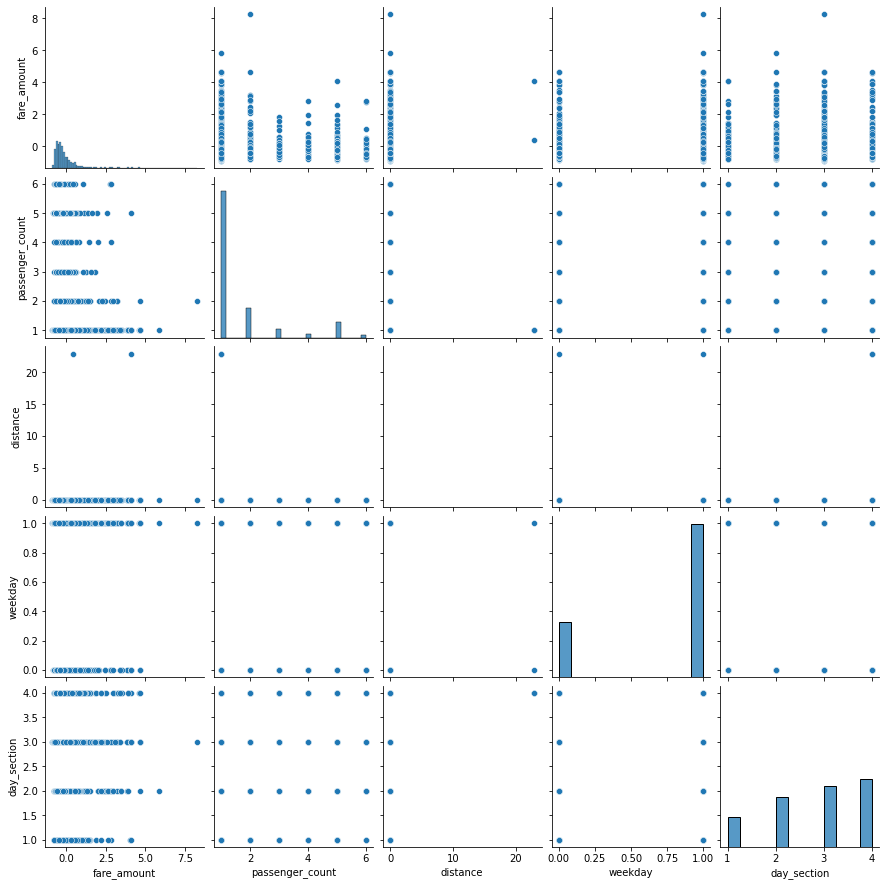

In [16]:
to_plot=uber[:1500]
sns.pairplot(to_plot)

<AxesSubplot:>

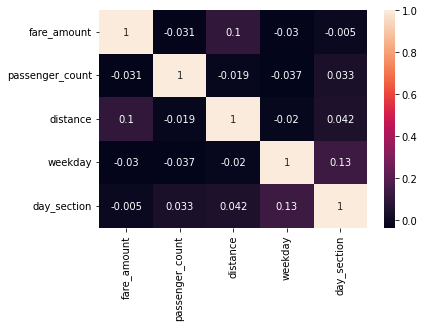

In [17]:
sns.heatmap(to_plot.corr(),annot=True)

## Training and Testing Datasets

Now that the data has been cleaned and normalized, we can start separating our dataset into training and testing subsets.<br/>
We are using Stratified data instead of random data to obtain a sample population that best represents the actual data, where each subgroup is properly represented.<br/>
Since we will be using Stratified K-Fold Cross Validation to check the accuracy of our models, we will 

In [18]:
# Predictor Variables
x = uber.drop('fare_amount', axis=1)
# Target Variable
y = uber['fare_amount']

In [19]:
# Stratified Sampling
train_set, test_set = train_test_split(uber, test_size=0.2, random_state=42, stratify=uber['weekday'])

# Y is the target
X_test = test_set.drop('fare_amount', axis=1)
Y_test = test_set['fare_amount']
X_train = train_set.drop('fare_amount', axis=1)
Y_train = train_set['fare_amount']

## Models

We will create a few different models and test their accuracies later on.<br/>
Since we are trying to predict `fare_amount`, we must use Regression Algorithms since it is a continuous variable.

### Linear Regression

Linear Regression is a method that attempts to model relationships between the target variable and the set of the predictor variables.

In [20]:
lreg = linear_model.LinearRegression()

In [21]:
lreg.fit(X_train, Y_train)

LinearRegression()

#### Stratified K Fold Cross Validation

We will use K Fold Cross Validation to test how accurate this model is. We will use K = 10 because that is the recommended value.

In [22]:
scores = sklearn.model_selection.cross_val_score(lreg, X_test, Y_test, cv=10)

In [23]:
print('Mean Score: ', scores.mean())

Mean Score:  0.0015307764504378985


We can see here that the scores for the Linear Regression model are not great.

### Decision Tree Regression

Decision Tree Regression is a supervised learning algorithm that works for both categorical and continuous target variables.<br/>
This type of regression uses a flowchart-like tree structure of decisions and all of their possible results, including outcomes, input costs, and utility.

#### Grid Search CV

In order to improve the accuracy of our models, we will be executing hyperparameter tuning, using a Grid Search.

In [24]:
from sklearn.tree import DecisionTreeRegressor 

params={'criterion': ['squared_error', 'friedman_mse'], 
        'splitter': ['best', 'random']        
        }

gs=GridSearchCV(estimator=DecisionTreeRegressor(random_state = 0), param_grid=params, cv=10)
# now fit the dataset to the GridSearchCV object. 
gs = gs.fit(x, y)

best_params=gs.best_params_
accuracy=gs.best_score_

print('Accuracy: ', accuracy)
print('Best Params: ', best_params)

Accuracy:  0.5220970955804742
Best Params:  {'criterion': 'friedman_mse', 'splitter': 'best'}


Now that we have the best hyperparameters, let's define our Decision Tree Regressor model.

In [25]:
tree_regressor = DecisionTreeRegressor(random_state = 0, criterion='friedman_mse', splitter='best')

In [26]:
tree_regressor.fit(X_train, Y_train)

DecisionTreeRegressor(criterion='friedman_mse', random_state=0)

#### K Fold Cross Validation

We will be using K Fold Cross Validation again to evaluate our system on the test data.

In [27]:
scores = sklearn.model_selection.cross_val_score(tree_regressor, X_test, Y_test, cv=10)

In [28]:
print('Mean Score: ', scores.mean())

Mean Score:  0.5615924350924963


We can see that the Decision Tree model is much more suitable to this dataset than the simple Linear Regression model we also built.